=== ANÁLISIS DEMOGRÁFICO COMUNIDAD DE MADRID ===

📊 POBLACIÓN TOTAL 2024: 7,009,268 habitantes
📈 CRECIMIENTO ANUAL: 1.4%
📅 PERIODO: 2021-2024

🏠 ESTRUCTURA POBLACIONAL 2024:
   • Jóvenes (0-14): 13.6%
   • Adultos (15-64): 67.7%
   • Mayores (65+): 18.6%
   • Índice dependencia: 47.6
   • Índice envejecimiento: 136.6

🏙️ TOP 5 MUNICIPIOS MÁS POBLADOS:
   • Madrid: 3,422,416 hab.
   • Móstoles: 213,268 hab.
   • Alcalá de Henares: 199,804 hab.
   • Leganés: 193,934 hab.
   • Getafe: 191,560 hab.

🚀 MAYOR CRECIMIENTO RELATIVO:
   • Horcajo de la Sierra-Aoslos: 11.0% anual
   • Robledillo de la Jara: 10.8% anual
   • Puebla de la Sierra: 7.4% anual
   • La Acebeda: 7.3% anual
   • Gascones: 7.3% anual


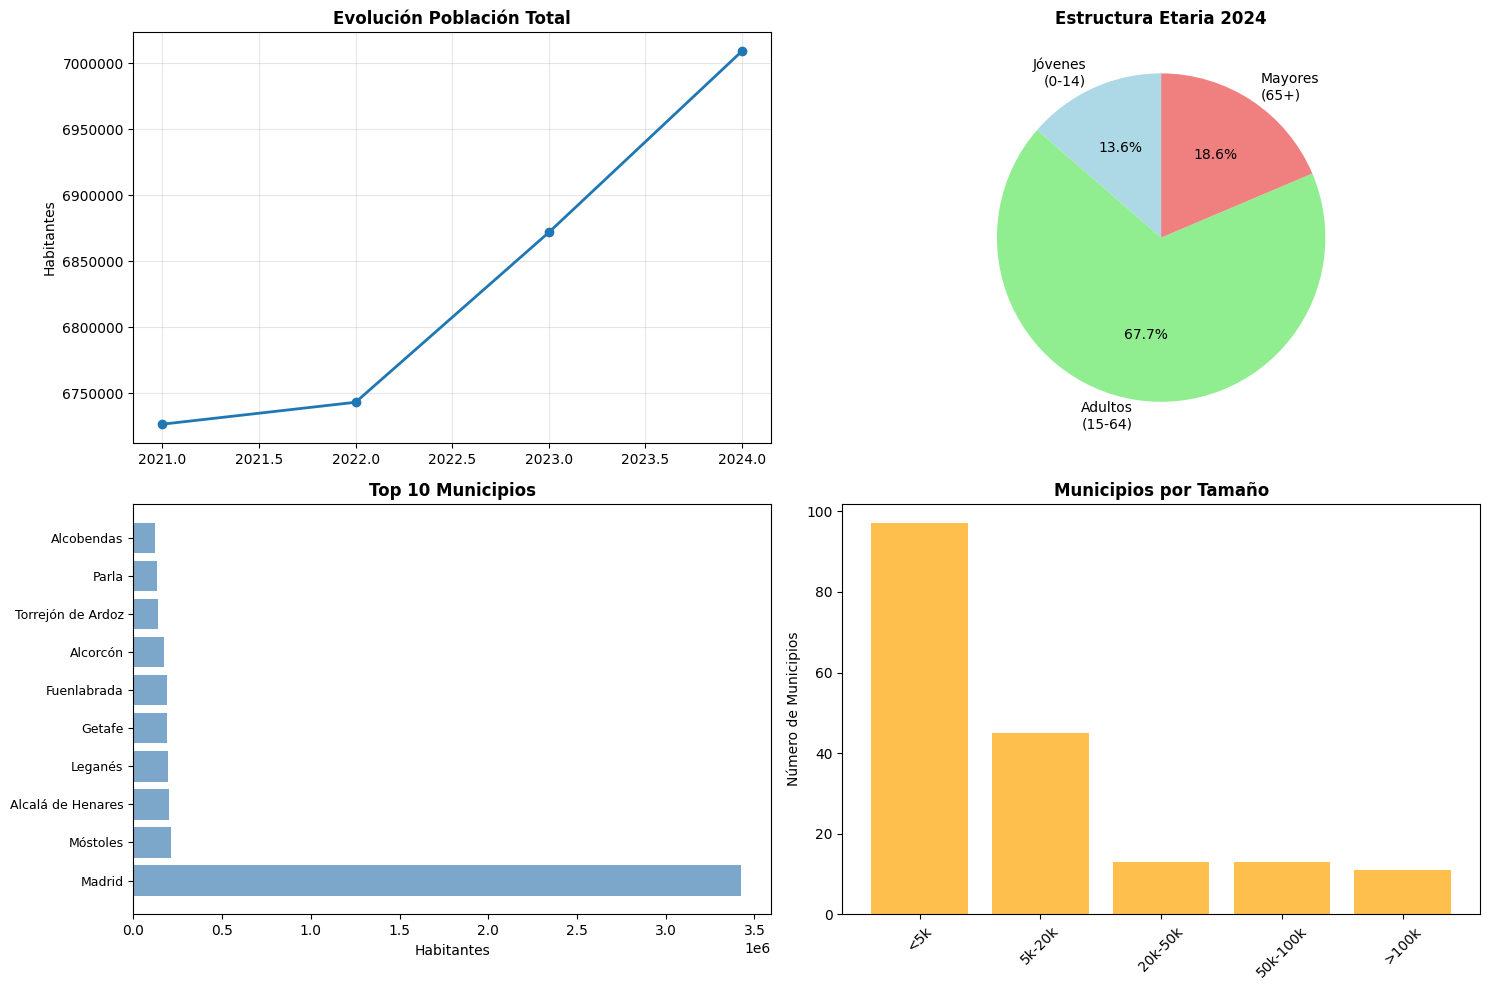


📊 DISTRIBUCIÓN TERRITORIAL:
   • 20k-50k: 13.0 municipios (363,093 hab.)
   • 50k-100k: 13.0 municipios (941,335 hab.)
   • 5k-20k: 45.0 municipios (458,620 hab.)
   • <5k: 97.0 municipios (160,996 hab.)
   • >100k: 11.0 municipios (5,085,224 hab.)


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Cargar datos
municipality_df = pd.read_csv('../downloads/normalizacion/municipality.csv', delimiter=',')
demographics_df = pd.read_csv('../downloads/normalizacion/municipality_demographics.csv', delimiter=',')

# Preparar datos
municipality_df.columns = [c.strip() for c in municipality_df.columns]
merged_df = demographics_df.merge(municipality_df, left_on='id_secondary_municipality', right_on='id_secondary', how='left')
agg_df = merged_df.groupby(['name_y', 'year', 'range'], as_index=False)['total'].sum()
agg_df['year'] = agg_df['year'].astype(int)
agg_df['total'] = agg_df['total'].astype(float)
agg_df = agg_df.rename(columns={'name_y': 'municipality_name'})

print("=== ANÁLISIS DEMOGRÁFICO COMUNIDAD DE MADRID ===\n")

# === RESUMEN EJECUTIVO ===
agg_df_total = agg_df[agg_df['range'].str.lower() == 'total']
latest_year = agg_df_total['year'].max()
earliest_year = agg_df_total['year'].min()
latest_pop = agg_df_total[agg_df_total['year'] == latest_year]
pop_evolution = agg_df_total.groupby('year')['total'].sum().reset_index()

total_actual = latest_pop['total'].sum()
if len(pop_evolution) > 1:
    years_diff = latest_year - earliest_year
    pop_inicial = pop_evolution.iloc[0]['total']
    tasa_crecimiento = ((total_actual / pop_inicial) ** (1/years_diff) - 1) * 100
else:
    tasa_crecimiento = 0

print(f"📊 POBLACIÓN TOTAL {latest_year}: {total_actual:,.0f} habitantes")
print(f"📈 CRECIMIENTO ANUAL: {tasa_crecimiento:.1f}%")
print(f"📅 PERIODO: {earliest_year}-{latest_year}")

# === INDICADORES CLAVE ===
def get_age_groups(df, year):
    df_year = df[(df['year'] == year) & (df['range'].str.lower() != 'total')]
    if df_year.empty:
        return None

    pop_by_range = df_year.groupby('range')['total'].sum()
    pop_0_14 = pop_by_range.filter(regex='^(0-4|5-9|10-14)$').sum()
    pop_15_64 = pop_by_range.filter(regex='^(15-19|20-24|25-29|30-34|35-39|40-44|45-49|50-54|55-59|60-64)$').sum()
    pop_65_plus = pop_by_range.filter(regex='^(65-69|70-74|75-79|80-84|85-89|90-94|95-99|100-n)$').sum()
    total = pop_0_14 + pop_15_64 + pop_65_plus

    if total == 0:
        return None

    return {
        'jovenes': (pop_0_14 / total) * 100,
        'adultos': (pop_15_64 / total) * 100,
        'mayores': (pop_65_plus / total) * 100,
        'dependencia': ((pop_0_14 + pop_65_plus) / pop_15_64) * 100 if pop_15_64 > 0 else 0,
        'envejecimiento': (pop_65_plus / pop_0_14) * 100 if pop_0_14 > 0 else 0
    }

current_indicators = get_age_groups(agg_df, latest_year)
if current_indicators:
    print(f"\n🏠 ESTRUCTURA POBLACIONAL {latest_year}:")
    print(f"   • Jóvenes (0-14): {current_indicators['jovenes']:.1f}%")
    print(f"   • Adultos (15-64): {current_indicators['adultos']:.1f}%")
    print(f"   • Mayores (65+): {current_indicators['mayores']:.1f}%")
    print(f"   • Índice dependencia: {current_indicators['dependencia']:.1f}")
    print(f"   • Índice envejecimiento: {current_indicators['envejecimiento']:.1f}")

# === TOP MUNICIPIOS ===
top5 = latest_pop.nlargest(5, 'total')
print(f"\n🏙️ TOP 5 MUNICIPIOS MÁS POBLADOS:")
for _, row in top5.iterrows():
    print(f"   • {row['municipality_name']}: {row['total']:,.0f} hab.")

# === CRECIMIENTO POR MUNICIPIO ===
if len(agg_df_total['year'].unique()) >= 2:
    growth_data = []
    for municipality in agg_df_total['municipality_name'].unique():
        muni_data = agg_df_total[agg_df_total['municipality_name'] == municipality].sort_values('year')
        if len(muni_data) >= 2:
            pop_inicial = muni_data.iloc[0]['total']
            pop_final = muni_data.iloc[-1]['total']
            years = muni_data.iloc[-1]['year'] - muni_data.iloc[0]['year']
            if pop_inicial > 0 and years > 0:
                tasa = ((pop_final / pop_inicial) ** (1/years) - 1) * 100
                growth_data.append({'municipio': municipality, 'tasa': tasa, 'absoluto': pop_final - pop_inicial})

    if growth_data:
        growth_df = pd.DataFrame(growth_data)
        top_growth = growth_df.nlargest(5, 'tasa')
        print(f"\n🚀 MAYOR CRECIMIENTO RELATIVO:")
        for _, row in top_growth.iterrows():
            print(f"   • {row['municipio']}: {row['tasa']:.1f}% anual")

# === VISUALIZACIONES SIMPLES ===
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# 1. Evolución población
ax1.plot(pop_evolution['year'], pop_evolution['total'], 'o-', linewidth=2, markersize=6)
ax1.set_title('Evolución Población Total', fontweight='bold')
ax1.set_ylabel('Habitantes')
ax1.grid(True, alpha=0.3)
ax1.ticklabel_format(style='plain', axis='y')

# 2. Estructura etaria actual
if current_indicators:
    labels = ['Jóvenes\n(0-14)', 'Adultos\n(15-64)', 'Mayores\n(65+)']
    values = [current_indicators['jovenes'], current_indicators['adultos'], current_indicators['mayores']]
    colors = ['lightblue', 'lightgreen', 'lightcoral']
    ax2.pie(values, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90)
    ax2.set_title(f'Estructura Etaria {latest_year}', fontweight='bold')

# 3. Top municipios
top10 = latest_pop.nlargest(10, 'total')
ax3.barh(range(len(top10)), top10['total'], color='steelblue', alpha=0.7)
ax3.set_yticks(range(len(top10)))
ax3.set_yticklabels([name[:20] for name in top10['municipality_name']], fontsize=9)
ax3.set_title('Top 10 Municipios', fontweight='bold')
ax3.set_xlabel('Habitantes')

# 4. Distribución por tamaño
def classify_size(pop):
    if pop >= 100000: return ">100k"
    elif pop >= 50000: return "50k-100k"
    elif pop >= 20000: return "20k-50k"
    elif pop >= 5000: return "5k-20k"
    else: return "<5k"

latest_pop['size_cat'] = latest_pop['total'].apply(classify_size)
size_counts = latest_pop['size_cat'].value_counts()
ax4.bar(size_counts.index, size_counts.values, color='orange', alpha=0.7)
ax4.set_title('Municipios por Tamaño', fontweight='bold')
ax4.set_ylabel('Número de Municipios')
plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.show()

# === CLASIFICACIÓN FINAL ===
size_distribution = latest_pop.groupby('size_cat').agg({'municipality_name': 'count', 'total': 'sum'})
print(f"\n📊 DISTRIBUCIÓN TERRITORIAL:")
for cat, data in size_distribution.iterrows():
    print(f"   • {cat}: {data['municipality_name']} municipios ({data['total']:,.0f} hab.)")
